# Regression for predicting insurance claim cost

In order to offer competitive prices and hence attract customers to an otherwise undifferentiated product, insurers need to be able to predict how much any given insurance claim will cost them.
They also need to predict the cost of claims in advance so that they can offer their insurance packages without the risk of making a loss.

In [66]:
import pandas as pd    # for reading csv data
import numpy as np
from random import shuffle
import matplotlib.pyplot as plt

## Download and read the dataset

This dataset constists of 

rename the data file to `claim_costs.csv`

In [67]:
data = pd.read_csv('claim_costs.csv')
#data = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
data = np.array(data)     # convert to matrix

print(data)
print(data.shape)

[[9.48831226e+01 6.61797085e+00 4.61127054e+01 ... 2.14450883e+00
  1.37281866e+01 4.14286368e+03]
 [7.32642738e+01 9.97246823e+01 8.17092345e+01 ... 9.46795876e+01
  3.45941237e+01 8.34806742e+03]
 [6.75670459e+00 6.29765119e+01 4.58118575e+01 ... 2.84445387e+01
  2.94493562e+01 4.94751565e+03]
 ...
 [4.01979770e+01 2.92544351e+01 4.86059768e+01 ... 2.12417734e+01
  6.19442140e+01 7.81426029e+03]
 [1.37961192e+01 7.34018502e+01 1.55845465e+01 ... 6.50788691e+00
  8.85812544e+01 8.65646838e+03]
 [4.82804091e+01 4.76625752e+01 2.31347373e+01 ... 7.35452927e+01
  8.18142284e+01 9.09558940e+03]]
(321, 7)


## Normalising the dataset


In [68]:
# CENTER AROUND MEAN
features = data[:, :-1]
labels = data[:, -1]

features -= features.mean(axis=0)

# DIVIDE BY RANGE
max_features = features.max(axis=0)
min_features = features.min(axis=0)

ranges = max_features - min_features

features /= ranges
print(features)

print(features.shape)
labels = np.reshape(labels, (features.shape[0], 1))
print(labels.shape)

normalised_data = np.hstack((features, labels))


[[ 4.56608880e-01 -4.02556176e-01 -2.51665483e-02 -3.14549158e-01
  -5.06589672e-01 -3.62774752e-01]
 [ 2.38163618e-01  5.31369372e-01  3.34111445e-01  2.42400320e-01
   4.23818305e-01 -1.53736255e-01]
 [-4.33854741e-01  1.62759476e-01 -2.82030256e-02 -1.28739846e-01
  -2.42152035e-01 -2.05277408e-01]
 ...
 [-9.59511122e-02 -1.75496580e-01 -1.80488000e-06 -4.54418272e-03
  -3.14573331e-01  1.20261590e-01]
 [-3.62725757e-01  2.67332924e-01 -3.33289165e-01  9.29868675e-02
  -4.62717426e-01  3.87115979e-01]
 [-1.42830733e-02  9.14996194e-03 -2.57084617e-01  1.31357867e-01
   2.11320333e-01  3.19322766e-01]]
(321, 6)
(321, 1)


# Slitting the dataset into test, train and validation sets

In [69]:
n_data = normalised_data
shuffle(n_data)

print(len(n_data))

train_size =int( 0.8 * len(n_data) )
val_size = int( 0.15 * len(n_data) )
test_size = len(n_data) - train_size - val_size

train_data = n_data[ : train_size]
val_data = n_data[train_size : train_size + val_size]
test_data = n_data[train_size + val_size :]


print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

321
(256, 7)
(48, 7)
(17, 7)


# Create the data loader

In [85]:
class DataLoader():
    
    def __init__(self, dataset, batch_size):
        self.batches = []
        i = 0
        while i + batch_size < len(dataset):
            self.batches.append(dataset[i:i+batch_size])
            i += batch_size
        self.batches.append(dataset[i:])
        #shuffle(self.batches)
        
    def __getitem__(self, idx):
        if idx == 0:
            shuffle(self.batches)
        #print(type(self.batches))
        batch = self.batches[idx]
        features = batch[:, :-1]
        labels = batch[:, -1]
        return features, labels

train_loader = DataLoader(train_data, 5)
val_loader = DataLoader(val_data, 5)

## Creating the model

We are going to creat a function to map our inputs to our output (confidence of transaction being false)
We will use a linear model as a function

In [86]:
class LinearModel():
    
    def __init__(self, n_features=6, n_outputs=1):
        self.weights = np.random.randn(n_outputs, n_features)    
        self.biases = np.random.randn(n_outputs)
        print(self.weights.shape)
        print(self.biases.shape)
    
    def __call__(self, x):
        x = np.matmul(self.weights, x.T)
        x += self.biases
        return x
    
linear_model = LinearModel()

(1, 6)
(1,)


# Creating the loss function

The loss function is a measure of how badly the model is currently performing. 

# $L = \frac{1}{2m} \sum^m_{i=1} (\hat{y} - y)^2 = \frac{1}{2m} \sum^m_{i=1} ( (WX + b) - y)^2$ 

In [101]:
def loss_fn(model, batch, gradient=False):
    x, y = batch
    #print('y:', y)
    #print(y.shape)
    
    y_hat = model(x)
    
    #print('y_hat:', y_hat)
    #print(y_hat.shape)
    
    if gradient == False:
        loss = 0.5 * np.mean( np.power( (y_hat - y), 2 ) )
        print(loss)
        
        return loss

    if gradient == True:
        z = model(x)
        print('z', (z-y).shape)
        print(x.shape)
        
        w_grad = (np.matmul( ( z - y ), x ) )
        print(w_grad)
        
        b_grad = np.mean( z - y )
        return w_grad, b_grad

# Creating the optimiser
The optimiser will update the parameters (weights and biases) of the model in a direction that reduces the error.

In [102]:
class SGDOptimiser():
    
    def __init__(self, model, lr=0.1):
        self.model = model
        self.lr = lr
        
    def step(self, grad):
        w_grad, b_grad = grad
        self.model.weights -= self.lr * w_grad        
        self.model.biases -= self.lr * b_grad
        
optimiser = SGDOptimiser(linear_model)

# Train the model

1.0043796832348874e-07
Epoch: 0 	Batch: 0 	Loss: 1.0043796832348874e-07
z (1, 5)
(5, 6)
[[ 2.08864216e-04 -4.67807159e-05 -3.15027275e-04 -2.71095520e-05
   1.11595368e-04 -2.40572854e-04]]
Validating
1.9247924147140866e-07
val_loss: 1.9247924147140866e-07
2.6129701390306127e-07
val_loss: 2.6129701390306127e-07
1.0158455128439571e-07
val_loss: 1.0158455128439571e-07
3.937486302687592e-07
val_loss: 3.937486302687592e-07
4.2843911290254537e-07
val_loss: 4.2843911290254537e-07
2.709630331762568e-07
val_loss: 2.709630331762568e-07
3.1146462297505366e-07
val_loss: 3.1146462297505366e-07
7.363024067714255e-08
val_loss: 7.363024067714255e-08
3.880202797545977e-07
val_loss: 3.880202797545977e-07
4.0301831867800125e-08
val_loss: 4.0301831867800125e-08
2.562514730500461e-07
Epoch: 0 	Batch: 1 	Loss: 2.562514730500461e-07
z (1, 5)
(5, 6)
[[ 3.27438468e-04  5.98785044e-04 -9.19314177e-04  8.67431540e-04
  -3.86495837e-05 -2.84402291e-04]]
4.07967595940366e-08
Epoch: 0 	Batch: 2 	Loss: 4.0796759594

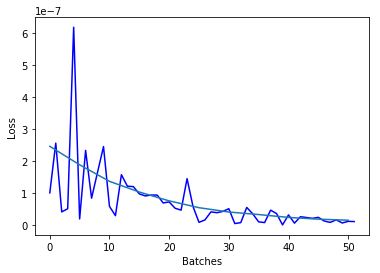

In [106]:
def train(model, epochs=1):
    
    e = []        # just a list to store the batch_idxs where validation happened
    
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        for batch_idx, batch in enumerate(train_loader):
            loss = loss_fn(model, batch)
            print('Epoch:', epoch, '\tBatch:', batch_idx, '\tLoss:', loss)
            w_grad, b_grad = loss_fn(model, batch, gradient=True)
            optimiser.step((w_grad, b_grad))
            
            train_losses.append(loss)

            if batch_idx % 5 == 0:
                print('\tValidating')
                batch_losses = []
                for val_batch in val_loader:
                    l = loss_fn(model, val_batch)
                    batch_losses.append(l)
                avg_batch_loss = np.mean(batch_losses)
                print('\tAverage batch loss:', )
                e.append(batch_idx)
                val_losses.append(avg_batch_loss)
                
    plt.plot(train_losses, 'b')
    plt.plot(e, val_losses)
    plt.xlabel('Batches')
    plt.ylabel('Loss')
    plt.show()
            
train(linear_model)

# Testing the model

Now we have seen our model learn from the training set, validated this with the validation set and used that to adjust the hyperparameters. Now we need to test the model by seeing how it performs on unseen examples.

In [ ]:
# test the model